In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import HTML,Latex
import os 
from joblib import Parallel,delayed
import json

In [2]:
class DNN:
    def __init__(self,layers):
        # layers :  list of dicts containing later information.
        assert type(layers) in  (list,tuple)
        assert len(layers) >= 2, "At least an input and an output layer should be there"
        
        # validate each layer
        for i,layer in enumerate(layers):
            if i==0:
                assert layer["type"] == "input", "first layer should be input"
            elif i==len(layers)-1:
                assert layer["type"] == "output", "last layer should be output"
            else:
                assert layer["type"] == "hidden", "middle layers should be hidden"
                assert layer["activation_function"] in ACTIVATION_FUNC
                
            assert type(layer["units"]) == int
            
            #if the reqularization term is not mentioned --> assign 0.0
            if 'regularization_strength' not in layer:
                layer['regularization_strength'] = 0.0
            # if the keep prob is not mentioned --> assign 1.0
            if 'dropout_keep_prob' not in layer:
                layer['dropout_keep_prob'] = 1.0
            
            #validate the regularization and keep prob values
            assert type(layer['regularization_strength']) == type(layer['dropout_keep_prob']) == float,\
                    "regularization_strength and dropout_keep_prob should be float"
                
        #done: validation
        
        #save these info
        self.layers = layers
        
        #keep state variables
        self.ever_trained = 0
        
        #costs need to be saved separately per each training
        self.cost_history = []
        
    def absorb_parameters(self,W,B):
        self.W=W
        self.B=B
        
    def build(self,show=0):
        # the parameters will be initialized with required dimentions
        
        self.W = [None] # this array will keep weight matrix  per each layer (l=1,2,..,L) ... first elem as a placeholde to indeces to work fine
        self.B = [None] # this array will keep bias vector  per each layer (l=1,2,..,L) ... first elem as a placeholde to indeces to work fine
        self.activation_def = [None] # the pointer to respecting activation function's definition per each layer (l=1,2,..,L) ... first elem as a placeholde to indeces to work fine
        self.activation_derivative_def = [None] # the pointer to respecting activation function's derivative's  
                                                                #definition per each layer (l=1,2,..,L) ... first elem as a placeholde to indeces to work fine
        
        self.A = [] # keep all intermidiate activation matrix per each layer (l=1,2,..,L)
        self.Z = [] # keep all intermidiate pre-activation matrix per each layer (l=1,2,..,L)
        
        #initializing
        for i in range(len(self.layers)):
            
            # anything for l=0,1,2,..,L ? 
            # NO
             
            
            if i: #only start from layer 1,2,..,L
                weight_matrix = np.random.randn(self.layers[i]["units"],self.layers[i-1]["units"]) * 0.01
                bias_vector = np.zeros((self.layers[i]["units"],1))
                self.W.append(weight_matrix)
                self.B.append(bias_vector)
                   
               
                self.activation_def.append(ACTIVATION_FUNC[self.layers[i]["activation_function"]])
                self.activation_derivative_def.append(ACTIVATION_FUNC_DERI[self.layers[i]["activation_function"]])
           
            
        if show: 
            print(self.W) 
            print(self.B)
            
            
    def show_cost_history(self):
        PLOT_COLORS = ['blue','red','green','orange']
        fig,ax = plt.subplots(1)
        pointer = 0
        for i,cost_histry_batch in enumerate(self.cost_history):
            ax.plot(list(range(pointer,pointer:=pointer + len(self.cost_history[i]))),
                    self.cost_history[i],
                    color=PLOT_COLORS[i%len(PLOT_COLORS)])
        plt.show()
        
        
    def predict(self,X):
        # these are some place holders to keep the arrays in required size
        self.A = [None for i in range(len(self.layers))]
        self.Z = [None for i in range(len(self.layers))]
        self.A[0] = X # the input matrix
        
       
        for i in range(1,len(self.layers)):
                    self.Z[i] = self.W[i]@self.A[i-1]+self.B[i]
                    self.A[i] = self.activation_def[i](self.Z[i])
        # now all the activations in the NN are calculated and stored
        
        return self.A[len(self.layers) - 1]
        
        
       
        
        
        
    def batch_fit(self,X,Y,cost_function='least_square',n_iters=1_000,learning_rate=1e-3):
        assert cost_function in ('least_square','binary_cross_entropy')
        Y = np.float64(Y)
        
      
        
        if not self.ever_trained:
            # these are some place holders to keep the arrays in required size
            self.A = [None for i in range(len(self.layers))]
            self.Z = [None for i in range(len(self.layers))]

            self.dZ = [None for i in range(len(self.layers))]
            self.dA = [None for i in range(len(self.layers))]
            self.dW = [None for i in range(len(self.layers))]
            self.dB = [None for i in range(len(self.layers))]
            
            #update the state variable
            self.ever_trained += 1
        else:
            print("Training again..fine tuning of parameters continued from where left at last time...")

        
        self.A[0] = X # set the input matrix 
        # apply droput settings for the input layer only
        should_dropout = np.random.rand(*self.A[0].shape) < self.layers[0]["dropout_keep_prob"]
        self.A[0] *= should_dropout /  self.layers[0]["dropout_keep_prob"]
       
        
        
        
        self.cost_history.append([])
        start_time = time.time()
        for iteration in range(n_iters): 
            
                # progress message : every 100 iteration except for the first one
                if iteration and not iteration%100:
                        time_now = time.time()
                        time_remaining = get_nice_time_dura_str ((n_iters - iteration) * (time_now - start_time) / iteration)
                        print(f"iteration : {iteration} ---> ETA : {time_remaining} ",end="\r")
            
            
                ##### FWD PASS #####
                #  r3ki3g : assumes the X in pre-scaled / normalized
                
                
                # loop though each layer and calculate the pre-activations(Z) and activations(A)
                cost_reg_term = 0
                for i in range(1,len(self.layers)):
                    self.Z[i] = self.W[i]@self.A[i-1]+self.B[i]
                    self.A[i] = self.activation_def[i](self.Z[i])
                    
                    # consider the drop-out settings
                    should_dropout = np.random.rand(*self.A[i].shape) < self.layers[i]["dropout_keep_prob"]
                    self.A[i] *= should_dropout /  self.layers[i]["dropout_keep_prob"]
                    
                    #iclude the regularization term in cost function (temp:cost_reg_term )
                    cost_reg_term += np.sum(self.W[i]**2) * self.layers[i]["regularization_strength"] / X.shape[1]
                    
                # now all the activations in the NN are calculated and stored
                
                
                # now calculate the cost at this iteration
                if cost_function == 'binary_cross_entropy':
                    cost = - np.sum((Y * np.log(self.A[len(self.layers) - 1]) + (1-Y) * np.log(1 - self.A[len(self.layers) - 1]))) /  X.shape[1] 
                elif cost_function == 'least_square':
                     cost = np.sum((self.A[len(self.layers) - 1] - Y)**2) / X.shape[1]
                else:
                    raise Exception("not implemented yet")
                
                #inlcude the regularization term in cost function
                cost += cost_reg_term
                self.cost_history[-1].append(cost)
                # done : cost calc and stroing

               

                ##### BACK PROP #####
                # The order l = L,L-1,L-2,...,3,2,1 (and no 0)
                for i in range(len(self.layers) -1 , 0 , -1): # i=0 is excluded  # note :- L is at  len(self.layers) -1 index

                    # dZ[L] depends on the choice of cost function
                    if i == len(self.layers) -1:
                                if cost_function == 'binary_cross_entropy':
                                    dL_dA = -(Y/self.A[i]) +((1-Y)/(1-self.A[i]))   
                                        
#                                        
                                elif cost_function == 'least_square':
                                    dL_dA = 2 * (self.A[i] - Y)
                                    
                                   
                                    
                                # finally we need the dZ (independent from cost function)
                                self.dZ[i] = dL_dA * self.activation_derivative_def[i](self.Z[i])



                    else: # not the last layer
                        self.dZ[i] =  (self.W[i+1].T @ self.dZ[i+1]) * self.activation_derivative_def[i](self.Z[i])
                    
                    
                    # calculate gradients
                    m = X.shape[1]
                    self.dW[i] = self.dZ[i]@self.A[i-1].T / m
                    self.dB[i] = np.sum(self.dZ[i],axis=1,keepdims=1) / m

                    # gradient decent
                    # the regularization has to be included here
                    reg_lambda =  self.layers[i]['regularization_strength']
                    self.W[i] = (1 - reg_lambda*learning_rate/m) * self.W[i] - learning_rate * self.dW[i]
                    self.B[i] = self.B[i] - learning_rate * self.dB[i]

                
        time_now = time.time()
        total_time = get_nice_time_dura_str(time_now - start_time)
        print(f"Training ended : n_iters: {n_iters} with learning_rate : {learning_rate}. Time taken : {total_time}")
                
            
        
                      

    
    
###### HELPER FUNCTIONS FOR DNN CLASS ###########    
    
# define activation functions globally
def sigmoid(t):
        return 1/ ( 1 + np.exp(-t) )
      
def relu(t): # from chat gpt : this is safe for any dimension array t
    return np.maximum(0,t)

def relu_deri(t):
    return np.where(t>=0,1.,0.)

def sigmoid_deri(t):
    return (1-sigmoid(t)) * sigmoid(t)

def linear(t):
    return t

def linear_deri(t):
    return 1

def tanh(Z):
    return np.tanh(Z)

def tanh_deri(Z):
    return 1 - np.tanh(Z)**2
                
ACTIVATION_FUNC = {"relu":relu,"sigmoid":sigmoid,"linear":linear,"tanh":tanh}
ACTIVATION_FUNC_DERI = {"relu":relu_deri,"sigmoid":sigmoid_deri,"linear":linear_deri,"tanh":tanh_deri}




# helper function for displaying ETA in a nice manner
def get_nice_time_dura_str(time_in_secs):
    time_in_secs = round(time_in_secs,2)
    if time_in_secs >= 60:
        n_mins = int(time_in_secs//60)
        n_secs = round(time_in_secs%60,2)
        return f"{n_mins} min {n_secs} secs"
    return f"{time_in_secs} secs"



## Testing


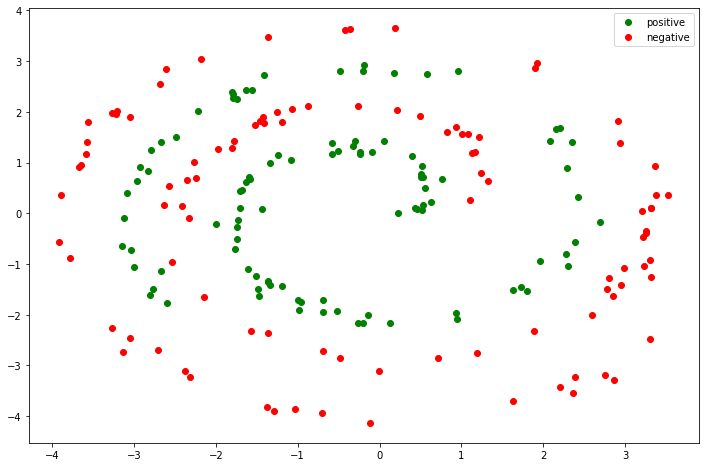

In [3]:
#testing

def get_spiral_distribution(n_points=100,noise_stats=(0,0),revolutions=1,radial_offset=0):
    '''
    Generate a set of (x1,x2) domain for spiral with mentioned noise stats : (mean,sigma)
    '''
    theta = np.random.rand(n_points) * 2 * np.pi * revolutions
    radius = np.sqrt(theta) + radial_offset
    mean,sigma = noise_stats
    noise_for_radius = np.random.randn(n_points) * sigma + mean
    radius += noise_for_radius
    x1 = radius * np.cos(theta)
    x2 = radius * np.sin(theta)
    X = np.concatenate((x1.reshape(1,-1),x2.reshape(1,-1)))
    return X



spiral_X1 = get_spiral_distribution(revolutions=1.6,noise_stats=(0,0.1))
spiral_X2 = get_spiral_distribution(revolutions=1.9,radial_offset=0.8,noise_stats=(0,0.1))


#plot and see
fig,ax = plt.subplots(1,figsize=(12,8))
ax.scatter(spiral_X1[0,:],spiral_X1[1,:],color='green',label='positive')
ax.scatter(spiral_X2[0,:],spiral_X2[1,:],color='red',label='negative')
plt.legend()
plt.show()

    

In [4]:
# create the data set <-- combine positive and negative examples to a single array
X_spiral_train = np.hstack((spiral_X1,spiral_X2))
Y_spiral_train = np.hstack( ( np.ones((1,spiral_X1.shape[1])),
                              np.zeros((1,spiral_X2.shape[1])) ))

Training ended : n_iters: 10000 with learning_rate : 0.01. Time taken : 3.62 secs


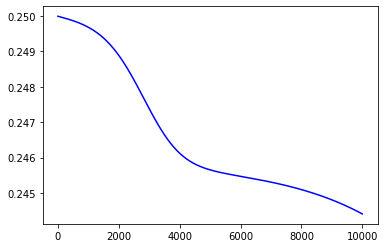

In [10]:
my_spiral_fa = DNN(layers=[

    {
        "type":"input",
        "units":2
    },


    {
        "type":"hidden",
        "units":16,
        "activation_function":"tanh",
        "regularization_strength":0.0,
        "dropout_keep_prob":1.0
    },
    
    {
        "type":"output",
        "units":1,
        "activation_function":"sigmoid",
        "regularization_strength":0.0,
        "dropout_keep_prob":1.0
    }

])

my_spiral_fa.build()

my_spiral_fa.batch_fit(X_spiral_train,
                       Y_spiral_train,
                       cost_function=('least_square','binary_cross_entropy')[0],
                       n_iters=1_0_000,
                       learning_rate=1e-2)


my_spiral_fa.show_cost_history()



#evaluate
predictions = np.int32(my_spiral_fa.predict(X_spiral_train) > 0.5)
accuracy = (predictions == Y_spiral_train).sum() / Y_spiral_train.shape[1]

display(HTML(f"<br/><font color='red' size='5'><b>Accuracy : {accuracy}</b></font>"))



Training again..fine tuning of parameters continued from where left at last time...
Training ended : n_iters: 100000 with learning_rate : 0.01. Time taken : 43.81 secs


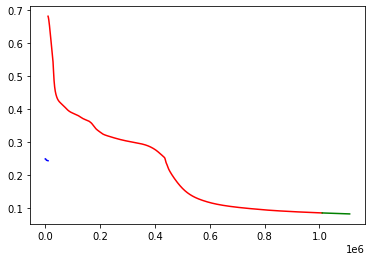

In [15]:
my_spiral_fa.batch_fit(X_spiral_train,
                       Y_spiral_train,
                       cost_function=('least_square','binary_cross_entropy')[1],
                       n_iters=1_00_000,
                       learning_rate=1e-2)


my_spiral_fa.show_cost_history()



#evaluate
raw_preds = my_spiral_fa.predict(X_spiral_train)
predictions = np.int32(raw_preds > 0.5)
accuracy = (predictions == Y_spiral_train).sum() / Y_spiral_train.shape[1]

display(HTML(f"<br/><font color='red' size='5'><b>Accuracy : {accuracy}</b></font>"))



## Visualize the results

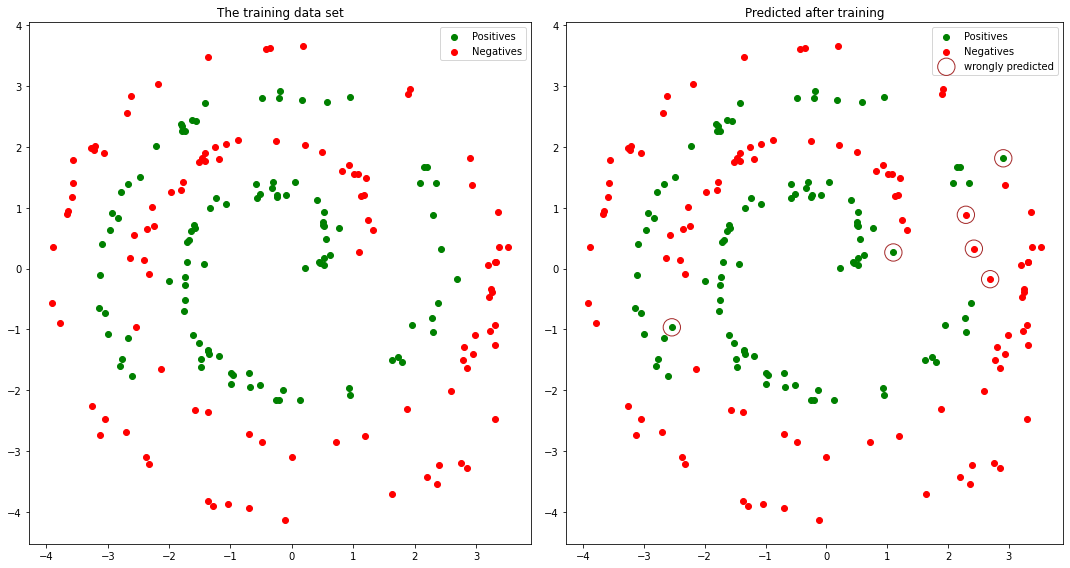

In [16]:
# from predictions clasify the training set in to positive and negatives
pred_positives = X_spiral_train[:,predictions.reshape(-1)==1]
pred_negatives = X_spiral_train[:,predictions.reshape(-1)!=1]

#filter the wrongly identified ones
wrong_ones = X_spiral_train[:,predictions.reshape(-1)!=Y_spiral_train.reshape(-1)]

#plot and see
fig,ax = plt.subplots(1,2,figsize=(15,8))

ax[0].scatter(spiral_X1[0,:],spiral_X1[1,:],color='green',label="Positives")
ax[0].scatter(spiral_X2[0,:],spiral_X2[1,:],color='red',label="Negatives")
ax[0].set_title("The training data set")

ax[1].scatter(pred_positives[0,:],pred_positives[1,:],color='green',label="Positives")
ax[1].scatter(pred_negatives[0,:],pred_negatives[1,:],color='red',label="Negatives")
ax[1].set_title("Predicted after training")

ax[1].scatter(wrong_ones[0,:],wrong_ones[1,:],facecolors='none', edgecolors='brown', s=300,label="wrongly predicted")

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.gca().set_aspect('equal')

plt.show()

## Seeing the output for entire domain 

In [13]:
def raw_pred_to_color(raw_preds,positive_color=[0,255,0],negative_color=[255,0,0]):
    print()
    '''
    positive_color,negative_color : the colors to represent 1 and 0
                                    values in between will see the combination of color
    raw_preds : outputs from the classifications (between 0 and 1 , end points inclusive)
    '''
    
    positive_color = np.array(positive_color).reshape(3,-1)
    negative_color = np.array(negative_color).reshape(3,-1)
    raw_preds = raw_preds.reshape(raw_preds.shape[1])
    
    color = np.int16(positive_color * raw_preds +  negative_color  *  (1 - raw_preds))
    return color
    
    

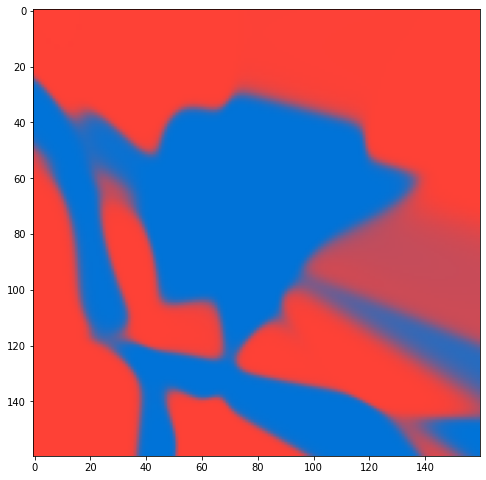

In [19]:
domain = [-4,4]
sampling_rate = 20

x1 = np.arange(*domain,1/sampling_rate)
x2 = np.arange(*domain,1/sampling_rate)
height = x1.shape[0]

xx1,xx2 = np.meshgrid(x1,x2)

xx1 = xx1.reshape(1,-1)
xx2 = xx2.reshape(1,-1)

X = np.vstack((xx1,xx2))

raw_preds = my_spiral_fa.predict(X)

colors = raw_pred_to_color(raw_preds,positive_color=[0,116,217],negative_color=[255,65,54]).T

background_image = colors.reshape(height,height,-1)


fig,ax = plt.subplots(1,figsize=(8,15))
ax.imshow(background_image)
plt.show()